In [143]:
from climatenet.utils.data import ClimateDatasetLabeled, ClimateDataset
from climatenet.models import CGNet
from climatenet.utils.utils import Config
from climatenet.track_events import track_events
from climatenet.analyze_events import analyze_events
from climatenet.visualize_events import visualize_events

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import cartopy.crs as ccrs
import pickle
import numpy as np
from os import path
import glob
import xarray as xr
import concurrent.futures
import subprocess

# Prepare ERA5 and MOAAP files as input for ClimateNet

## prepare files for 2019-04

In [3]:
ds_tcwv=xr.open_dataset('/work/aa0049/a271109/data_misc/ERA5/data_processed/TCWV_ERA5_2019-04_1H_remapped.nc')
ds_u850=xr.open_dataset('/work/aa0049/a271109/data_misc/ERA5/data_processed/U850hPa_ERA5_2019-04_1H_remapped.nc')
ds_v850=xr.open_dataset('/work/aa0049/a271109/data_misc/ERA5/data_processed/V850hPa_ERA5_2019-04_1H_remapped.nc')
ds_msl=xr.open_dataset('/work/aa0049/a271109/data_misc/ERA5/data_processed/MSL_ERA5_2019-04_1H_remapped.nc')

In [4]:
ds_moaap=xr.open_dataset('/work/aa0049/a271109/tools/MOAAP_AWI/output/ObjectMasks_ERA5_2019-04_global.nc')
ds_moaap
lat_tmp=ds_moaap.rlat.isel(xc=0).values #time=0,
lon_tmp=ds_moaap.rlon.isel(yc=0).values #time=0,
ds_moaap=ds_moaap.drop(['rlat','rlon']).rename_dims({'yc':'lat','xc':'lon'}).assign_coords(lat=lat_tmp,lon=lon_tmp)

## prepare files for 2020-04

In [154]:
ds_tcwv=xr.open_dataset('/work/aa0049/a271109/data_misc/ERA5/data_processed/TCWV_ERA5_2020-04_1H_remapped.nc')
ds_u850=xr.open_dataset('/work/aa0049/a271109/data_misc/ERA5/data_processed/U850hPa_ERA5_2020-04_hourly_remapped.nc')
ds_v850=xr.open_dataset('/work/aa0049/a271109/data_misc/ERA5/data_processed/V850hPa_ERA5_2020-04_hourly_remapped.nc')
ds_msl=xr.open_dataset('/work/aa0049/a271109/data_misc/ERA5/data_processed/MSL_ERA5_2020-04_hourly_remapped.nc')

In [ ]:
ds_moaap=xr.open_dataset('/work/aa0049/a271109/tools/MOAAP_AWI/output/ObjectMasks_ERA5_2020-04_global.nc')
ds_moaap
lat_tmp=ds_moaap.rlat.isel(xc=0).values #time=0,
lon_tmp=ds_moaap.rlon.isel(yc=0).values #time=0,
ds_moaap=ds_moaap.drop(['rlat','rlon']).rename_dims({'yc':'lat','xc':'lon'}).assign_coords(lat=lat_tmp,lon=lon_tmp)


In [ ]:
for tt in ds_tcwv.time[::1][:]: #[::6]
    print(str(tt.values))

    ds_vars_sel = ds_tcwv.sel(time=tt)
    ds_vars_sel = ds_vars_sel.expand_dims(dim='time')
    ds_vars_sel = ds_vars_sel.rename_vars({'TCWV':'TMQ'})

    ds_vars_sel['U850']=ds_u850.U.sel(time=tt).isel(plev=0).expand_dims(dim='time')
    ds_vars_sel['V850']=ds_v850.V.sel(time=tt).isel(plev=0).expand_dims(dim='time')
    ds_vars_sel['PSL']=ds_msl.MSL.sel(time=tt).expand_dims(dim='time')

    # Create a base LABELS array with all values initialized to 0
    labels = xr.zeros_like(ds_moaap.IVT_Objects.sel(time=tt), dtype='int64')    
    # Set LABELS to 1 where CY_Objects > 0
    labels = xr.where(ds_moaap.CY_Objects.sel(time=tt) > 0, 1, labels)    
    # Set LABELS to 2 where IVT_Objects > 0 (this will overwrite the previous 1s if applicable)
    labels = xr.where(ds_moaap.IVT_Objects.sel(time=tt) > 0, 2, labels)    
    # Assign the modified labels back to the ds_vars_sel dataset
    ds_vars_sel['LABELS'] = labels
    
    #ds_vars_sel['LABELS']=(ds_moaap.IVT_Objects.sel(time=tt)>0)*2
    
    filename_out='data-{}.nc'.format(tt.dt.strftime('%Y-%m-%d-%H').item())

    # ds_vars_sel.to_netcdf('/work/aa0049/a271109/spice-v2.1/chain/work/run_era5_polarres_wp3_hindcast2_IHE/post/processed_JLa/climatenet_input/train_ERA5-MOAAP_2019-04/'+filename_out)
    ds_vars_sel.to_netcdf('/work/aa0049/a271109/spice-v2.1/chain/work/run_era5_polarres_wp3_hindcast2_IHE/post/processed_JLa/climatenet_input/test_ERA5-MOAAP_2020-04/'+filename_out)

    #del ds_vars_sel, ds_vars_sel_mod 


# Train ClimateNet on 2019-04 data

In [158]:
config = Config('config_cpu.json')
cgnet = CGNet(config)

train_path = '/work/aa0049/a271109/spice-v2.1/chain/work/run_era5_polarres_wp3_hindcast2_IHE/post/processed_JLa/climatenet_input'
inference_path = '/work/aa0049/a271109/tools/ClimateNet/data/'

In [159]:
train = ClimateDatasetLabeled(path.join(train_path, 'train_ERA5-MOAAP_2019-04'), config)
test = ClimateDatasetLabeled(path.join(train_path, 'test_ERA5-MOAAP_2020-04'), config)
# inference = ClimateDataset(inference_path, config)
inference = ClimateDataset(path.join(train_path, 'test_ERA5-MOAAP_2020-04'), config)


In [88]:
cgnet.train(train)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1:


Loss: 0.7158017158508301: 100%|██████████| 30/30 [09:49<00:00, 19.65s/it]

Epoch stats:
[[51021482. 12537086.  4607733.]
 [ 9811525. 28454497.  4557973.]
 [ 2661811.  3220468.  7716225.]]
IOUs:  [0.63270972 0.48572456 0.338963  ] , mean:  0.48579909334279664


In [90]:
cgnet.save_model('trained_cgnet_era5moaap_2019-04_cpu')
# use a saved model with
# cgnet.load_model('trained_cgnet')

In [160]:
cgnet.load_model('trained_cgnet_era5moaap_2019-04_cpu')

# Infer IVT object shapes for 2020-04

In [161]:
class_masks = cgnet.predict(inference) # masks with 1==TC, 2==AR
# event_masks = track_events(class_masks) # masks with event IDs

# analyze_events(event_masks, class_masks, 'results/')
# visualize_events(event_masks, inference, 'pngs/')

100%|██████████| 90/90 [11:50<00:00,  7.89s/it]


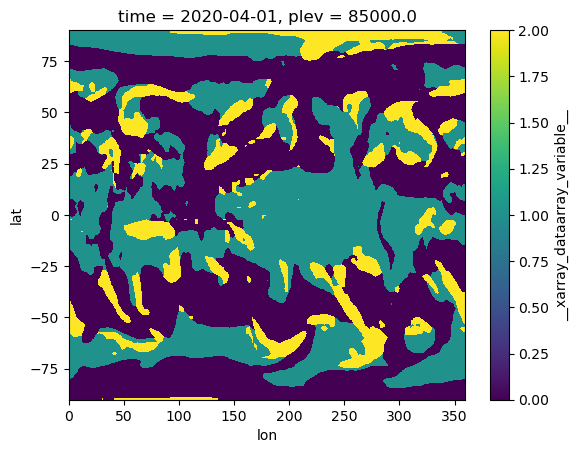

In [175]:
class_masks.isel(time=0).plot()

In [17]:
event_masks = track_events(class_masks) # masks with event IDs

identifying connected components..
tracking components across time..


100%|██████████| 120/120 [08:18<00:00,  4.16s/it]


num TCs: 35
num ARs: 138


# Plot IVT object shapes from MOAAP and ClimateNet for each time step on a map

In [176]:
# Define the plotting function
def moaap_object_plot(tt,save_figs=False,show_figs=True):

    fig, ax = plt.subplots(1,1,figsize=(10,5),subplot_kw={'projection': ccrs.Robinson()})

    tt_mod=str(tt.values.astype('datetime64[h]'))

    ds=xr.open_dataset('/work/aa0049/a271109/spice-v2.1/chain/work/run_era5_polarres_wp3_hindcast2_IHE/post/processed_JLa/climatenet_input/test_ERA5-MOAAP_2020-04/data-{}.nc'.format(tt.dt.strftime('%Y-%m-%d-%H').item()))
    
    ivt=ds.TMQ.sel(time=tt)*(ds.V850.sel(time=tt)**2+ds.U850.sel(time=tt)**2)**0.5
    ivt.isel(lon=slice(None,None,4),lat=slice(None,None,4)).plot(vmin=0,vmax=500,cmap='Blues',ax=ax,transform=ccrs.PlateCarree(),\
                                                                   cbar_kwargs={'shrink':0.8,'label':'$\mathsf{IWV*\sqrt{U_{850hPa}^2+V_{850hPa}^2}}$ (kg*m⁻¹*s⁻¹)'})
    ds.LABELS.plot.contour(levels=1,colors='b',ax=ax,transform=ccrs.PlateCarree())
    (class_masks.sel(time=tt)==2).plot.contour(levels=1,colors='r',ax=ax,transform=ccrs.PlateCarree())
    
    climatenet_handle = mlines.Line2D([], [], color='r', label='ClimateNet (trained on MOAAP labels for 2019-04 6hourly, using ERA5 IWV, $\mathsf{U_{850hPa}}$, $\mathsf{V_{850hPa}}$)')
    moaap_handle = mlines.Line2D([], [], color='b', label='MOAAP (using ERA5 IVT)')
    ax.legend(handles=[moaap_handle, climatenet_handle],loc='lower left',labelspacing=0.1,fontsize=9);
    ax.set_title(tt_mod)
    # ax.gridlines(linestyle=':')
    ax.coastlines(color='grey')
    fig.suptitle('Moisture Transport Anomaly Objects from MOAAP and ClimateNet Neural Network',fontweight='bold',y=0.90);

    if save_figs==True:
        output_path = '/work/aa0049/a271109/scripts/movies/movie_MOAAP_ERA5ClimateNet_2020-04/{}.jpg'.format(tt_mod.replace(":", "-"))
        fig.savefig(output_path, dpi=200, bbox_inches="tight")

    if show_figs==True:
        plt.show()
    else:
        plt.clf()
        plt.close(fig)
        
    print(tt_mod)

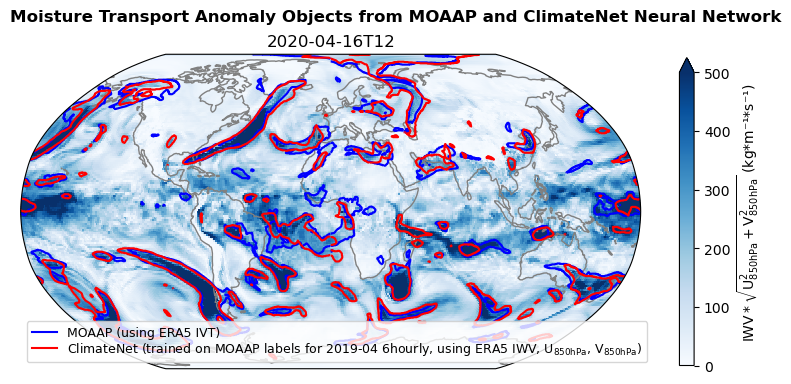

2020-04-16T12


In [179]:
moaap_object_plot(class_masks.sel(time='2020-04-16T12').time,save_figs=False,show_figs=True)

In [ ]:
# for tt in objs_plot_times[:]:
#     moaap_object_plot(tt,additional_stuff=True,save_figs=True,show_figs=False)

### parallelized version:
with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(moaap_object_plot, tt,save_figs=True,show_figs=False) for tt in class_masks.time] 
    concurrent.futures.wait(futures)



# Create an animation

In [ ]:
ffmpeg_bin = '/work/aa0049/a271109/sw/ffmpeg-6.0-yypn3q/bin/ffmpeg'
input_images = '/work/aa0049/a271109/scripts/movies/movie_MOAAP_ERA5ClimateNet_2020-04/*.jpg'
path_output_video = '/work/aa0049/a271109/scripts/movies/movie_MOAAP_ERA5ClimateNet_2020-04.mp4'

# Reduced bitrates for the lower framerate
bitrate = '1500k'  # 750k reduced by a factor of 5
maxrate = '2250k'  # 1125k reduced by a factor of 5

command_pass1 = (
    f"{ffmpeg_bin} -y -r 12 -pattern_type glob -i '{input_images}' "
    f"-c:v libx264 -b:v {bitrate} -vf 'scale=trunc(iw/2)*2:trunc(ih/2)*2' "
    f"-x264-params 'pass=1:vbv-bufsize=1500:vbv-maxrate={maxrate}' -an -f mp4 /dev/null"
)
command_pass2 = (
    f"{ffmpeg_bin} -y -r 12 -pattern_type glob -i '{input_images}' "
    f"-c:v libx264 -b:v {bitrate} -vf 'scale=trunc(iw/2)*2:trunc(ih/2)*2' "
    f"-x264-params 'pass=2:vbv-bufsize=1500:vbv-maxrate={maxrate}' -an {path_output_video}"
)

print(command_pass1)
print(command_pass2)

# Run the two-pass encoding
subprocess.run(command_pass1, cwd='/work/aa0049/a271109/scripts/movies/movie_MOAAP_ERA5ClimateNet_2020-04/', shell=True, check=True)
subprocess.run(command_pass2, cwd='/work/aa0049/a271109/scripts/movies/movie_MOAAP_ERA5ClimateNet_2020-04/', shell=True, check=True)


<video src="./movie_MOAAP_ERA5ClimateNet_2020-04.mp4">